<a href="https://colab.research.google.com/github/CristhianSeverino/Polars_Experimentation/blob/En-Proceso/EDAWithPolars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalar e Importar Librerias**

> Ten en cuenta que este es un EDA Basico, Consideralo un MVP.
Aun requiere un apartado de ingenieria de caracteristicas e identificacion de isigths mas profundos


In [29]:
!pip install polars matplotlib seaborn plotly kaggle

In [30]:
!pip install kagglehub[polars-datasets]


In [31]:
# Import libraries // Importar Librerias
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
import numpy as np
print("="*50)
print("Librerias importadas")
print("="*50)

Librerias importadas


# **Optencion  y estructuracion de datos**


In [32]:
# Establece la variable de entorno para que apunte al directorio donde está kaggle.json.
# En Caso de no tener el Json de Kagle. ve a tu cuenta de kagel en configuraciones y genera tu clave API.
# En Google Colab, este es típicamente '/content'.
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

# Este comando descarga el conjunto de datos y lo descomprime en el mismo directorio.
!kaggle datasets download -d olistbr/brazilian-ecommerce --unzip

Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
  0% 0.00/42.6M [00:00<?, ?B/s]
100% 42.6M/42.6M [00:00<00:00, 515MB/s]


In [33]:
#                                                    1. Optencion del archivo
#==============================================================================================================================

# Obten la ruta para el direcotio de descarga del archivo. si deseas usar otro data set. modifica el codigo segun la necesidad ;)

# Carga los conjuntos de datos en DataFrames de Polars.
# Polars inferirá automáticamente los tipos de datos de los archivos CSV.
orders = pl.read_csv("olist_orders_dataset.csv")
items = pl.read_csv("olist_order_items_dataset.csv")
products = pl.read_csv("olist_products_dataset.csv")
categories = pl.read_csv("product_category_name_translation.csv")


# Muestra el número de filas y columnas para cada DataFrame para confirmar que se cargaron correctamente.
print("Orders Shape:", orders.shape)
print("Items Shape:", items.shape)
print("Products Shape:", products.shape)
print("Categories Shape:", categories.shape)



Orders Shape: (99441, 8)
Items Shape: (112650, 7)
Products Shape: (32951, 9)
Categories Shape: (71, 2)


In [34]:
# Step 2: Data Cleaning and Preparation // Preparacion y limpieza de datos

# Join datasets for a denormalized view: orders -> items -> products -> categories

df = (
    orders.join(items, on="order_id", how="inner")
    .join(products, on="product_id", how="left")
    .join(categories, on="product_category_name", how="left")
)

# Select relevant columns similar to Superstore (adapt to Olist schema)
# Columns: order_id, order_purchase_timestamp, order_status, customer_id, price, freight_value, product_category_name_english (as Category), etc.
df = df.select([
    pl.col("order_id"),
    pl.col("customer_id"),
    pl.col("order_status"),
    pl.col("order_purchase_timestamp").alias("Order Date"),
    pl.col("order_delivered_customer_date").alias("Delivery Date"),
    pl.col("price").alias("Sales"),
    pl.col("freight_value").alias("Freight"),
    pl.col("product_id"),
    pl.col("product_category_name_english").alias("Category"),
    # Add more if needed, e.g., seller_id, payment from other files
])

# Check for null values // Verificaion de nulos
null_counts = df.null_count()
print("\nNull Counts:\n", null_counts)

# Handle missing values: Drop rows with null in key columns like Sales, Order Date
df = df.drop_nulls(subset=["Sales", "Order Date", "Category"])

# Convert date columns to datetime
df = df.with_columns([
    pl.col("Order Date").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S").alias("Order Date"),
    pl.col("Delivery Date").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S").alias("Delivery Date")  # May have nulls
])

# Add derived columns: Year, Month, Total Sales (price + freight?)
df = df.with_columns([
    pl.col("Order Date").dt.year().alias("Order Year"),
    pl.col("Order Date").dt.month().alias("Order Month"),
    (pl.col("Sales") + pl.col("Freight")).alias("Total Value")
])

# Filter for delivered orders if needed
df = df.filter(pl.col("order_status") == "delivered")


Null Counts:
 shape: (1, 9)
┌──────────┬─────────────┬──────────────┬────────────┬───┬───────┬─────────┬────────────┬──────────┐
│ order_id ┆ customer_id ┆ order_status ┆ Order Date ┆ … ┆ Sales ┆ Freight ┆ product_id ┆ Category │
│ ---      ┆ ---         ┆ ---          ┆ ---        ┆   ┆ ---   ┆ ---     ┆ ---        ┆ ---      │
│ u32      ┆ u32         ┆ u32          ┆ u32        ┆   ┆ u32   ┆ u32     ┆ u32        ┆ u32      │
╞══════════╪═════════════╪══════════════╪════════════╪═══╪═══════╪═════════╪════════════╪══════════╡
│ 0        ┆ 0           ┆ 0            ┆ 0          ┆ … ┆ 0     ┆ 0       ┆ 0          ┆ 1627     │
└──────────┴─────────────┴──────────────┴────────────┴───┴───────┴─────────┴────────────┴──────────┘


# **EDA**

In [35]:
# 3.1: Summary Statistics // estadisticas de Resumen
summary = df.describe()
print("\nSummary Statistics:\n", summary)


Summary Statistics:
 shape: (9, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ order_id  ┆ customer_ ┆ order_sta ┆ … ┆ Category  ┆ Order     ┆ Order     ┆ Total    │
│ ---       ┆ ---       ┆ id        ┆ tus       ┆   ┆ ---       ┆ Year      ┆ Month     ┆ Value    │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ str       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆           ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 108638    ┆ 108638    ┆ 108638    ┆ … ┆ 108638    ┆ 108638.0  ┆ 108638.0  ┆ 108638.0 │
│ null_coun ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ null      ┆ null      ┆ … ┆ 

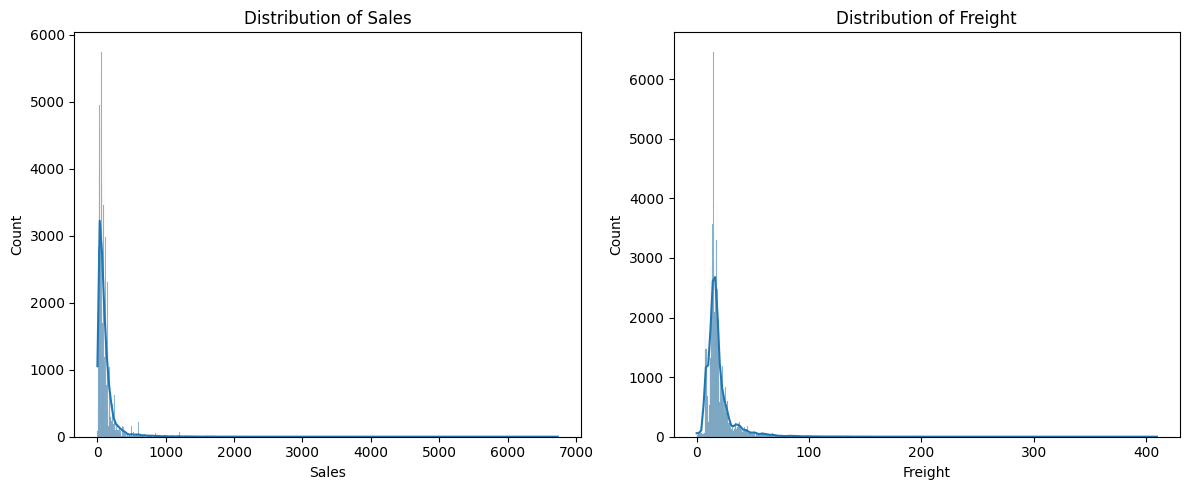

In [36]:
# 3.2: Univariate Analysis // Analisis univariable

# Numerical: Sales, Freight
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Convertir la serie de 'Sales' a Pandas para el trazado
sns.histplot(df["Sales"].to_pandas(), kde=True, ax=axes[0])
axes[0].set_title("Distribution of Sales")

# Convertir la serie de 'Freight' a Pandas para el trazado
sns.histplot(df["Freight"].to_pandas(), kde=True, ax=axes[1])
axes[1].set_title("Distribution of Freight")

plt.tight_layout()
plt.show()

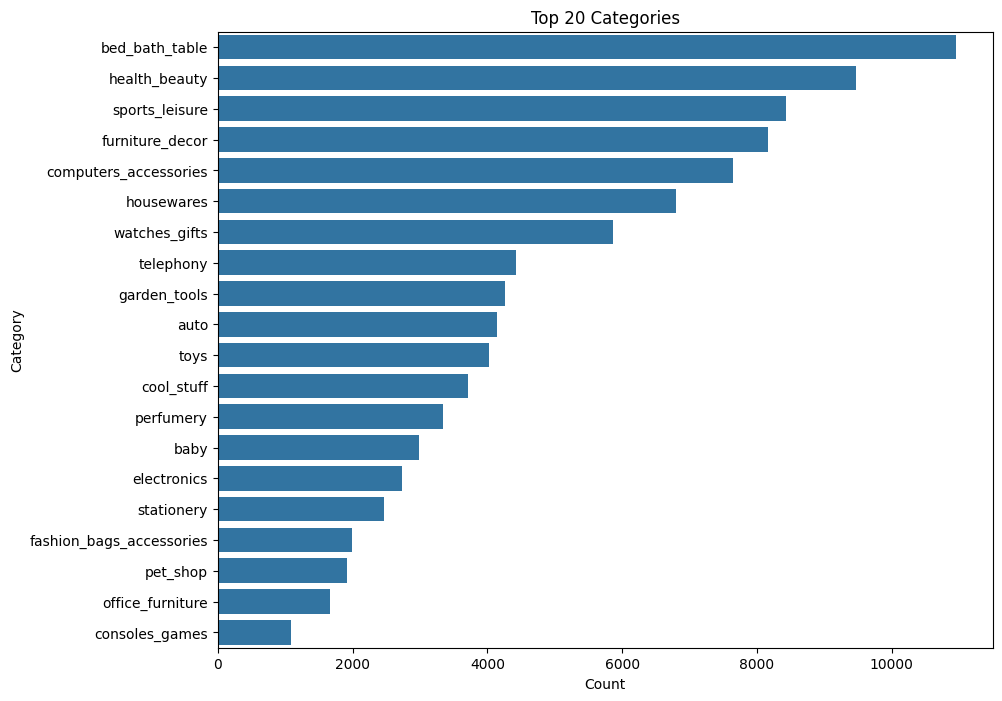

In [37]:
#Analisis univariable Categorias

top_20_categories = (
    df.group_by("Category")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(20)
)

# Convertir el resultado a Pandas para el trazado
top_20_pandas = top_20_categories.to_pandas()

plt.figure(figsize=(10, 8))
sns.barplot(y=top_20_pandas["Category"], x=top_20_pandas["count"])
plt.title("Top 20 Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


Sales by Category:
 shape: (20, 2)
┌───────────────────────┬─────────────┐
│ Category              ┆ Total Sales │
│ ---                   ┆ ---         │
│ str                   ┆ f64         │
╞═══════════════════════╪═════════════╡
│ health_beauty         ┆ 1.2331e6    │
│ watches_gifts         ┆ 1.1662e6    │
│ bed_bath_table        ┆ 1.0234e6    │
│ sports_leisure        ┆ 954852.55   │
│ computers_accessories ┆ 888724.61   │
│ …                     ┆ …           │
│ stationery            ┆ 223788.69   │
│ computers             ┆ 218684.14   │
│ pet_shop              ┆ 211695.64   │
│ musical_instruments   ┆ 184315.74   │
│ small_appliances      ┆ 182754.12   │
└───────────────────────┴─────────────┘


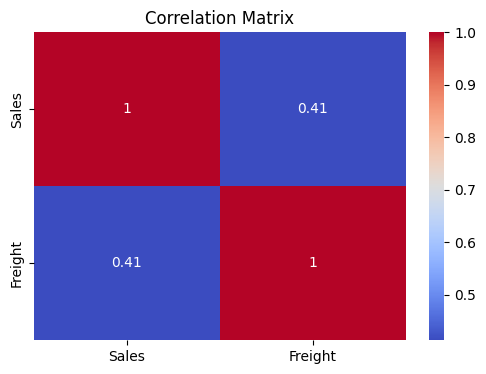

In [38]:
# 3.3: Bivariate Analysis // Analisis Bi-Variable

# Sales by Category
sales_by_category = df.group_by("Category").agg(pl.col("Sales").sum().alias("Total Sales")).sort("Total Sales", descending=True).head(20)
print("\nSales by Category:\n", sales_by_category)

# Interactive bar plot
fig = px.bar(sales_by_category.to_pandas(), x="Category", y="Total Sales", title="Total Sales by Category")
fig.show()

# Sales over Time (Monthly)
sales_over_time = df.group_by(["Order Year", "Order Month"]).agg(pl.col("Sales").sum().alias("Monthly Sales")).sort(["Order Year", "Order Month"])
fig = px.line(sales_over_time.to_pandas(), x="Order Month", y="Monthly Sales", color="Order Year", title="Monthly Sales Over Years")
fig.show()

# Correlation Matrix
num_df = df.select(["Sales", "Freight"]).to_pandas()  # Add more nums if available
corr_matrix = num_df.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [39]:
# 3.4: Multivariate Analysis// Analisis Multivariable

# Sales by Category and Year
sales_cat_year = df.group_by(["Category", "Order Year"]).agg(pl.col("Sales").sum().alias("Total Sales")).sort("Total Sales", descending=True)
fig = px.bar(sales_cat_year.to_pandas(), x="Category", y="Total Sales", color="Order Year", title="Sales by Category and Year")
fig.show()

In [40]:
# 3.5: Outlier Detection (e.g., in Sales) // deteccion de Outliers (E.J En vetas)
def detect_outliers(col_name):
    q1 = df.select(pl.col(col_name).quantile(0.25)).item()
    q3 = df.select(pl.col(col_name).quantile(0.75)).item()
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df.filter((pl.col(col_name) < lower_bound) | (pl.col(col_name) > upper_bound))
    return outliers

sales_outliers = detect_outliers("Sales")
print("\nNumber of Sales Outliers:", sales_outliers.shape[0])


Number of Sales Outliers: 8047
